# Example with ERA5 high-resolution (~0.25deg) monthly means


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>

# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) ([Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782)]). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change ([Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1)). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Load ERA5 data previously downloaded locally via [Jupyter Notebook - download ERA5](https://github.com/franzihe/download_ERA5)
* find clouds: liquid-only, ice-only, mixed-phase
* Regridd the ERA5 variables to the same horizontal resolution as high-resolution CMIP6 models with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate and plot the seasonal mean of the variable

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?


> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **1985 to 2014**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. The CMIP6 data analysis can be found in the [Jupyter Notebook for CMIP6](../cmip/CMIP6_hr_1985-2014.ipynb).

- Time period: 1985 to 2014
- horizonal resolution: ~0.25deg
- time resolution: monthly atmospheric data 
- Variables:
  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
| sf            |    snowfall                             |[m of water eq]| surface |
| msr           |    mean_snowfall_rate                   |[kg m-2 s-1]   | surface |
| cswc          |    specific_snow_water_content          | [kg kg-1]     |    pl   |
| clwc          |    specific_cloud_liquid_water_content  |   [kg kg-1]   |    pl   |
| clic          |    specific_cloud_ice_water_content     | [kg kg-1]     |    pl   |
| t             |    temperature                          |  [K]          |    pl   |
| 2t            |    2 metre temperature                  |  [K]          | surface |
| tclw          |   Total column cloud liquid water       |  [kg m-2]     | single  |
| tciw          |   Total column cloud ice water          |  [kg m-2]     | single  |
| tp            |   Total precipitation                   |  [m]          | surface |


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `/input/ERA5/monthly_means/0.25deg`.


In [1]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/scratch/franzihe/"
    FIG_DIR = "/uio/kant/geo-metos-u1/franzihe/Documents/Figures/ERA5/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/ERA5/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import(xr, intake, ccrs, cy, plt, glob, cm, fct, np, da)
xr.set_options(display_style='html')

In [3]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open ERA5 variables
Get the data requried for the analysis. Beforehand we downloaded the monthly averaged data on single levels and pressure levels via the Climate Data Store (CDS) infrastructure. The github repository [Download ERA5](https://github.com/franzihe/download_ERA5) gives examples on how to download the data from the CDS. We use the Jupyter Notebooks [download_Amon_single_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_single_level.ipynb) and [download_Amon_pressure_level](https://github.com/franzihe/download_ERA5/blob/main/download_Amon_pressure_level.ipynb). Both, download the monthly means for the variables mentioned above between 1985 and 2014.

> **_NOTE:_** To download from CDS a user has to have a CDS user account, please create the account [here](https://cds.climate.copernicus.eu/user/register).


In [4]:
era_in = os.path.join(INPUT_DATA_DIR, 'ERA5/monthly_means/0.25deg')
era_out = os.path.join(OUTPUT_DATA_DIR, 'ERA5/monthly_means/1deg')
# make output data directory
try:
    os.mkdir(era_out)
except OSError:
    pass

In [5]:
variable_id=[
            '2t',
            'clic',
            'clwc',
            'cswc',
            'msr',
            'sf',
            't', 
            'tciw',
            'tclw',
            'tp'
             ]

At the moment we have downloaded 30 years (1985-2014) for ERA5. We define start and end year to ensure to only extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year

We will load all available variables into one xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [6]:
# rsync -av --progress login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/0.25deg /scratch/franzihe/input/ERA5/monthly_means

In [7]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

ds_era = xr.Dataset()
for var_id in variable_id:
    # Input data from ERA5 with a resolution of 0.25x0.25deg to be regridded
    era_file_in = glob('{}/{}_Amon_ERA5_*12.nc'.format(era_in, var_id))       # search for data in the local directory 
    ds = xr.open_mfdataset(era_file_in, )

    
    # rename variable name in dataset to match variable_id
    if var_id == '2t':
        ds = ds.rename({'t2m':'2t'})
    if var_id == 'clic':
        ds = ds.rename({'ciwc':'clic'})
    ds_era[var_id] = ds[var_id].sel(time = ds.time.dt.year.isin(year_range)).squeeze() 

ds_era = ds_era.sel(time = ds_era.time.dt.year.isin(year_range)).squeeze()
# ds_era = fct.rename_coords_lon_lat(ds_era)
ds_era = ds_era.assign_coords(longitude=(((ds_era.longitude + 180) % 360) - 180)).sortby('longitude').sortby('time')


In [8]:
# create pressure array 
ds_era['pressure'] = xr.DataArray(data=da.ones(shape = ds_era['clic'].shape, 
), 
                                                               dims=list(ds_era['clic'].dims), 
                                                               coords=[ds_era.time.values, ds_era.level.values, ds_era.latitude.values, ds_era.longitude.values])

ds_era['pressure'] = ds_era['pressure']*ds_era['level'][::-1]
ds_era['pressure'] .attrs["units"] = 'hPa'
ds_era['pressure'] .attrs["long_name"] = 'Atmospheric pressure'

In [9]:
# create occcurence array 
for var_id in ds_era.data_vars:
    ds_era[var_id + '_occurence'] = xr.DataArray(data=da.ones(shape = (ds_era['time'].shape[0],ds_era['latitude'].shape[0], ds_era['longitude'].shape[0]), ), 
                                                                dims=[ds_era['time'].dims[0],ds_era['latitude'].dims[0], ds_era['longitude'].dims[0]] , 
                                                                coords=[ds_era['time'].values,ds_era['latitude'].values, ds_era['longitude'].values] )

    ds_era[var_id + '_occurence'].attrs["units"] = ''
    ds_era[var_id + '_occurence'].attrs["long_name"] = 'Occurence'

ds_era = ds_era.chunk(chunks={"time":60, "level":37, "latitude":721, "longitude":1440}) # we have to chunk the data like this as the regridding showed to have some trouble because of chunking

## Change attributes matching CMIP6 data

We will assign the attributes to the variables to make CMIP6 and ERA5 variables comperable.

The data [documentation of monthly means](https://confluence.ecmwf.int/pages/viewpage.action?pageId=82870405#ERA5:datadocumentation-Monthlymeans) gives information about the accumulations in monthly means (of daily means, stream=moda/edmo). Hence, the precipitation variables have been scaled to have an "effective" processing period of one day, so for accumulations in these streams
* [`sf`](https://apps.ecmwf.int/codes/grib/param-db?id=144) is in **m of water per day** $\rightarrow$  multiply by **1000** to get **kg m-2 day-1** or **mmday-1**.


* [`tp`](https://apps.ecmwf.int/codes/grib/param-db?id=228) is in **m** $\rightarrow$ Multiply by **1000** to get **mm**
* [`ciwc`](https://apps.ecmwf.int/codes/grib/param-db?id=247), [`clwc`](https://apps.ecmwf.int/codes/grib/param-db?id=246), and [`cswc`](https://apps.ecmwf.int/codes/grib/param-db?id=76) is in **kg kg-1**    $\rightarrow$ Multiply by **1000** to get **g kg-1**
* [`msr`](https://apps.ecmwf.int/codes/grib/param-db?id=235031) is in **kg m-2 s-1** $\rightarrow$ Multiply by **86400** to get **mm day-1**
* [`tciw`](https://apps.ecmwf.int/codes/grib/param-db?id=79) and [`tclw`](https://apps.ecmwf.int/codes/grib/param-db?id=78) is in **kg m-2** $\rightarrow$ Multiply by **1000** to get **g m-2**




In [10]:
for var_id in variable_id:
    
    if var_id == 'clic' or var_id == 'clwc' or var_id == 'cswc' or var_id == 'sf' or var_id == 'tciw' or var_id == 'tclw' or var_id == 'tp':
        ds_era[var_id] = ds_era[var_id]*1000
        
        if var_id == 'clic':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific cloud ice water content'}
            ds_era['clic'] = ds_era['clic'].where(ds_era['clic'] >= 10**(-6))
        if var_id == 'clwc':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific cloud liquid water content'}
            ds_era['clwc'] = ds_era['clwc'].where(ds_era['clwc'] >= 10**(-6))
        if var_id == 'cswc':
            ds_era[var_id].attrs = {'units': 'g kg-1', 'long_name':'Specific snow water content'}
            ds_era['cswc'] = ds_era['cswc'].where(ds_era['clwc'] >= 10**(-6))
        if var_id == 'sf':
            ds_era[var_id].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall',}
            ds_era['sf'] = ds_era['sf'].where(ds_era['sf'] >= 0., other= np.nan)
        if var_id == 'tciw':
            ds_era[var_id].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud ice water'}
        if var_id == 'tclw':
            ds_era[var_id].attrs = {'units': 'g m-2', 'long_name': 'Total column cloud liquid water'}
        if var_id == 'tp':
            ds_era[var_id].attrs = {'units': 'mm', 'long_name': 'Total precipitation'}
        
    if var_id == 'msr':
        ds_era[var_id] = ds_era[var_id]*86400
        ds_era[var_id].attrs = {'units': 'mm day-1', 'long_name': 'Mean snowfall rate'}

    

## Specific ice and snow water content

To get all all frozen particles in the column we have to add the variables `specific cloud ice content` and `specific snow water content`.

$$\sum clic + cswc = cisc$$ 


In [11]:
ds_era['cisc'] = ds_era['clic'] + ds_era['cswc']
ds_era['cisc'].attrs = {'units': 'g kg-1', 'long_name':'Specific cloud ice and snow water content'}

## Mask atmopsheric temperature

During the process of finding the SLF50, SLF30, SLF70 we encountered the problem, that the atmospheric temperature is too cold with $T<175K$. To avoid cold temperatures we will mask the atmospheric temperature values. For this we will try a few thresholds and see how it looks on a spatial map, if we are masking too many temperatures then we know that our threshold is too warm.

Test for:
- 150K = -123.15 $^oC$ 
- 175K = -98.15 $^oC$ 
- 200K = -73.15 $^oC$ 
- 210K = -63.15 $^oC$ 
- 220K = -53.15 $^oC$
- 230K = -43.15 $^oC$ 

We have different possibilities to mask the temperature:
1. Mask t, but the all other vertical variables still keep their values where t<threshold
2. Mask t, and all other vertical variables where t<threshold
3. Mask t, find the lowest pressure level and t, if t==NaN then take the atmospheric pressure, temperature from the layer above

> use Method 1. for now

In [12]:
var_id = 't'
temp = (150, 175, 200, 210, 220, 230)
for t in temp:
    ds_era['{}_{}'.format(var_id, t)] = ds_era[var_id].where(ds_era[var_id] >= t)

## Regrid ERA5 data to common NorESM2-MM grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) for the CMIP6 models in comparison to ERA5. 

The ERA5 data has a nominal resolution of 0.25 deg and has to be regridded to the same horizontal resolution as the NorESM2-MM. Hence we will make use of the python package `xesmf` and [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings).  

$\rightarrow$ Define NorESM2-MM as the reference grid `ds_out`.

Save all variables in one file and each variable to a `netcdf` datasets between 1985 an 2014, locally.

> **_NOTE:_** This can take a while, so be patient

### Open CMIP6 online catalog and search corresponding data
... by using `intake` from [pangeo.io](https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html), specifically `intake-esm`.

An example on [Loading an ESM collection](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection) and [searching for datasets](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#searching-for-datasets) can also be found on the [Pangeo / ESGF Cloud Data Working Group documentation](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html).

* using intake-esm’s `search()` function:
  * `col.search(variable_id, source_id, experiment_id, table_id, member_id, institution_id, grid_label)`

In [13]:
# Read in the output grid from NorESM

cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

cat = col.search(variable_id ='areacella', source_id = 'NorESM2-MM', experiment_id = 'historical', member_id=['r1i1p1f1'])

cmip_in = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_out = cmip_in['CMIP.NCC.NorESM2-MM.historical.fx.gn'].isel(member_id =0).drop(labels='areacella')
# Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
ds_out = ds_out.assign_coords(lon=(((ds_out.lon + 180) % 360) - 180)).sortby('lon')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [15]:
counter = 0

keys = 'ERA5'

# Regrid data
era_in_1deg = fct.regrid_data(ds_era, ds_out)


filename = '{}_Amon_1deg_{}01_{}12.nc'.format(keys,starty, endy)
era_file_out = os.path.join(era_out, filename)
files = glob(era_file_out)
if era_file_out in files:
#     print('{} is downloaded'.format(era_file_out))
#     counter += 1
#     print('Have regridded in total: {:} files'.format(str(counter))) 
# else: # Save to netcdf file
    era_in_1deg.to_netcdf(era_file_out)
    print('file written: {}'.format(era_file_out))


2t True
clic True
clwc True
cswc True
msr True
sf True
t True
tciw True
tclw True
tp True
pressure True
2t_occurence True
clic_occurence True
clwc_occurence True
cswc_occurence True
msr_occurence True
sf_occurence True
t_occurence True
tciw_occurence True
tclw_occurence True
tp_occurence True
pressure_occurence True
cisc True
t_150 True
t_175 True
t_200 True
t_210 True
t_220 True
t_230 True
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/ERA5_Amon_1deg_198501_201412.nc


In [16]:
for var_id in era_in_1deg.data_vars:
    if var_id.find('occurence')==-1:
        # select where data should be saved
        filename = '{}_{}_Amon_1deg_{}01_{}12.nc'.format(var_id, keys,starty, endy)
        era_file_out = os.path.join(era_out, filename)
        files = glob(era_file_out)
        if era_file_out in files:
        #     print('{} is downloaded'.format(era_file_out))
        #     counter += 1
        #     print('Have regridded in total: {:} files'.format(str(counter))) 
        # else: # Save to netcdf file
            era_in_1deg[var_id].to_netcdf(era_file_out)
            print('file written: {}'.format(era_file_out))

file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/2t_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/clic_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/clwc_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/cswc_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/msr_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/sf_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/t_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/tciw_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/tclw_ERA5_Amon_1deg_198501_201412.nc
file written: /scratch/franzihe/output/ERA5/monthly_means/1deg/tp_ERA5_Amon_1deg_198501_201412.nc
file writt

In [17]:
# ERA5 data
# rsync -av --progress /scratch/franzihe/output/ERA5/monthly_means/1deg/ login.nird.sigma2.no:/projects/NS9600K/data/ERA5/monthly_means/1deg/

# 3. Exploratory Data Analysis <a id='exploratory'></a>

## Create global mean and seasonal mean/spread of all ERA5 data

In [18]:
# 0.25 deg resolution data
season_mean_025deg = ds_era.copy()
for var_id in ds_era.data_vars:
    if var_id.find('occurence')==-1:
        season_mean_025deg = fct.seasonal_mean_std(season_mean_025deg, var_id)
season_mean_025deg = season_mean_025deg.drop_dims('time')

# 1 deg resolution data
season_mean_1deg = era_in_1deg.copy()
for var_id in era_in_1deg.data_vars:
    if var_id.find('occurence')==-1:
        season_mean_1deg = fct.seasonal_mean_std(season_mean_1deg, var_id)
season_mean_1deg = season_mean_1deg.drop_dims('time')

## Find mixed-phase clouds
Calculate the IWC/LWC statistics given by the values. Setting the value to 0.5 will find the level in the atmosphere where IWC and LWC are 50/50. Setting it to a value of 0.7 will find the level where IWC is 70% while LWC is 30%.

1. find the fraction of IWC to LWC 
$$SLF = \frac{LWC}{IWC + LWC}$$ 
$$SLF: \text{Super-cooled liquid water fraction}$$

2. find the nearest value to given IWC-fraction
3. find atmospheric pressure levels where IWC/LWC fraction occurs
4. find the index of the first atmospheric pressure level
5. use the index to select variables


Create dictionary from the list of datasets we want to use for the IWC/LWC statistics


In [19]:
SLF = {'SLF50':0.5, 'SLF70':0.7, 'SLF30':0.5}


# find IWC/LWC levels
ds_era_025deg = fct.dataset_IWC_LWC_level(ds_era, SLF, 'clwc', 'cisc', keys)

ds_era_1deg = fct.dataset_IWC_LWC_level(era_in_1deg, SLF, 'clwc', 'cisc', keys)

season_mean_025deg = fct.dataset_IWC_LWC_level(season_mean_025deg, SLF, 'clwc_mean', 'cisc_mean', keys)

season_mean_1deg = fct.dataset_IWC_LWC_level(season_mean_1deg, SLF, 'clwc_mean', 'cisc_mean', keys)



## Plot the seasonal mean of each variable 

- for the original dataset
- and where the IWC/LWC level were found
    - for IWC/LWC 50/50
    - for IWC/LWC 70/30
    - for IWC/LWC 30/70   

All plots are for ERA resolution at 1 deg.


Text(0.5, 0.98, 'ERA5_SLF50 t (1985 - 2014)')

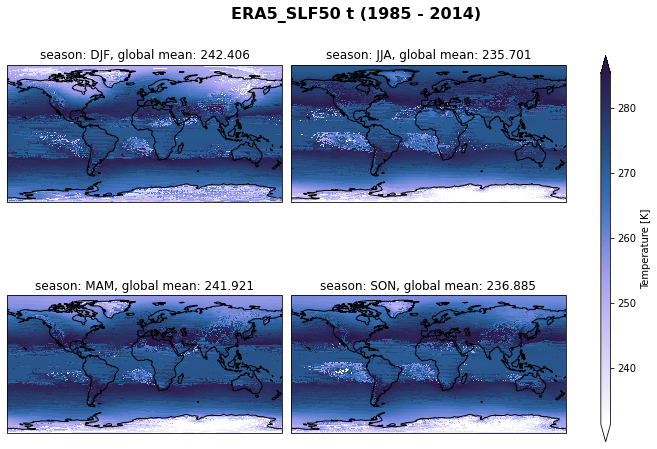

In [20]:
stat = 'ERA5_SLF50'
var_id = 't'
extend = 'both'
title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


fg = variable.plot(
        col="season",
        col_wrap=2,
        transform=ccrs.PlateCarree(),  # remember to provide this!
        subplot_kws={
            "projection": ccrs.PlateCarree()
        },
        cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
        cmap=cm.devon_r, 
        figsize=[10, 7],
        robust=True,
        extend=extend,
        # add_colorbar=False,
        # vmin=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmin')],
        # vmax=fct.plt_dict[var_id][fct.plt_dict['header'].index('vmax')],
        # levels=fct.plt_dict[var_id][fct.plt_dict['header'].index('levels')],
    )
for ax, i in zip(fg.axes.flat, variable.season.values):
        ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

fg.map(lambda: plt.gca().coastlines())
fg.fig.suptitle(title, fontsize=16, fontweight="bold")
# fg.add_colorbar(fraction=0.05, pad=0.04)

# fg.cbar.set_label(label='{}'.format(fct.plt_dict[var_id][fct.plt_dict['header'].index('label')], weight='bold'))
    

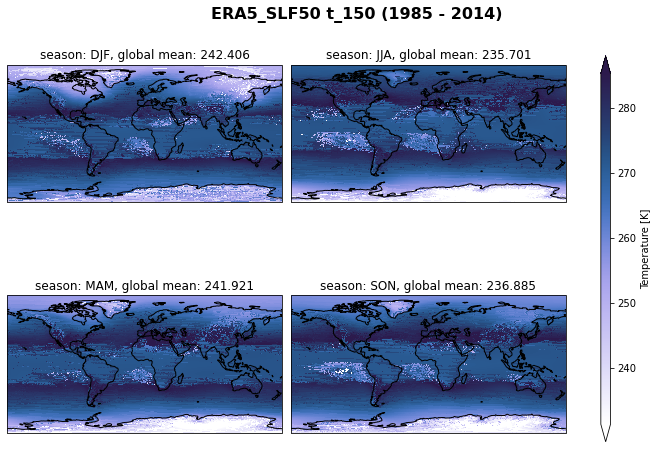

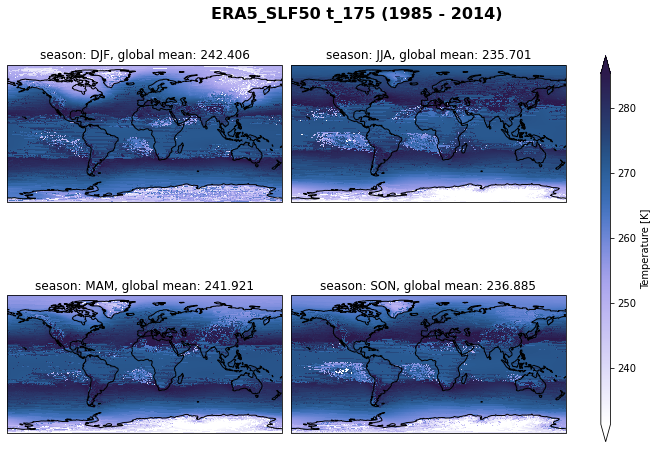

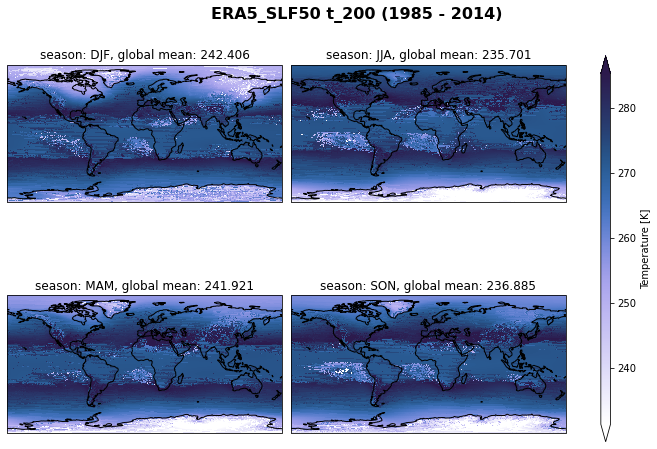

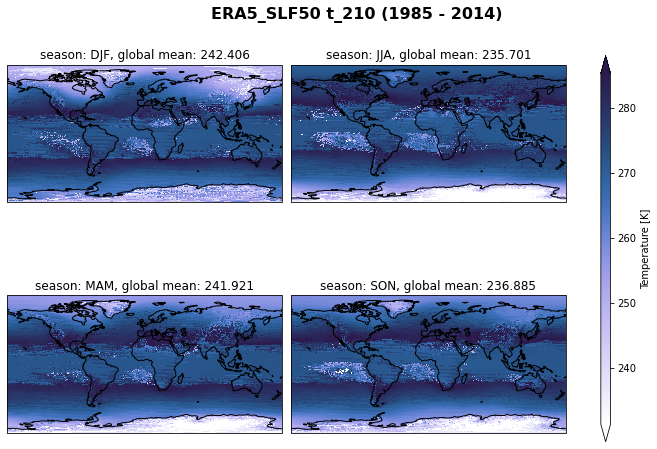

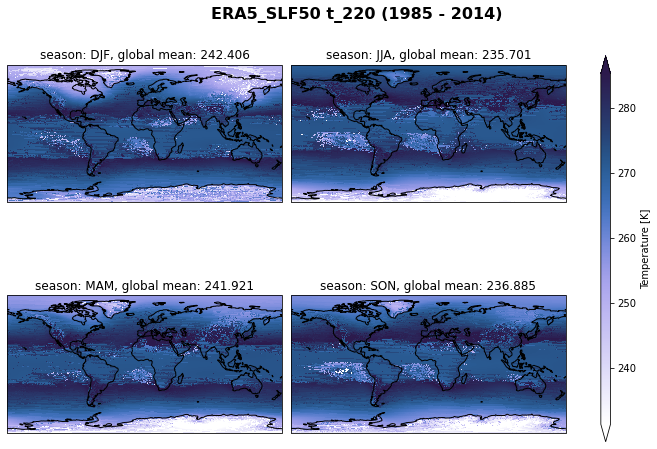

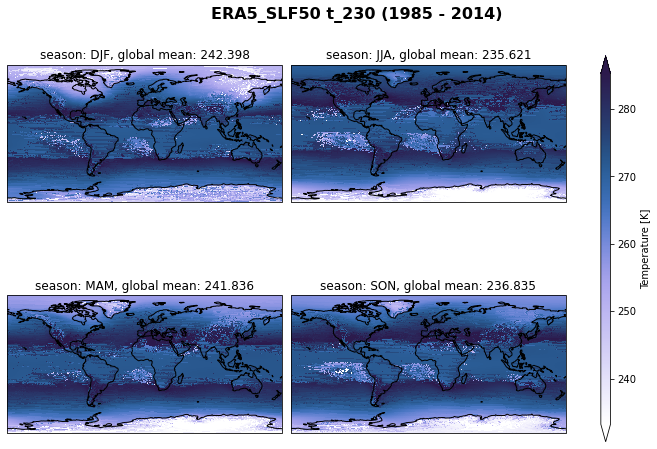

In [21]:
for t in temp:
    var_id = 't_{}'.format(t)
    title = '{} {} ({} - {})'.format(stat, var_id, starty, endy)

    variable = season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
                
    global_mean = ds_era_025deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('latitude', 'longitude'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)


    fg = variable.plot(
            col="season",
            col_wrap=2,
            transform=ccrs.PlateCarree(),  # remember to provide this!
            subplot_kws={
                "projection": ccrs.PlateCarree()
            },
            cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
            cmap=cm.devon_r, 
            figsize=[10, 7],
            robust=True,
            extend=extend,
            # add_colorbar=False,
            # vmin=fct.plt_dict['t'][fct.plt_dict['header'].index('vmin')],
            # vmax=fct.plt_dict['t'][fct.plt_dict['header'].index('vmax')],
            # levels=fct.plt_dict['t'][fct.plt_dict['header'].index('levels')],
        )

    for ax, i in zip(fg.axes.flat, variable.season.values):
        ax.set_title('season: {}, global mean: {:.3f}'.format(i, global_mean.sel(season=i).values))
    

    fg.map(lambda: plt.gca().coastlines())
    fg.fig.suptitle(title, fontsize=16, fontweight="bold")
    # fg.add_colorbar(fraction=0.05, pad=0.04)

    # fg.cbar.set_label(label='{}'.format(fct.plt_dict['t'][fct.plt_dict['header'].index('label')], weight='bold'))
        

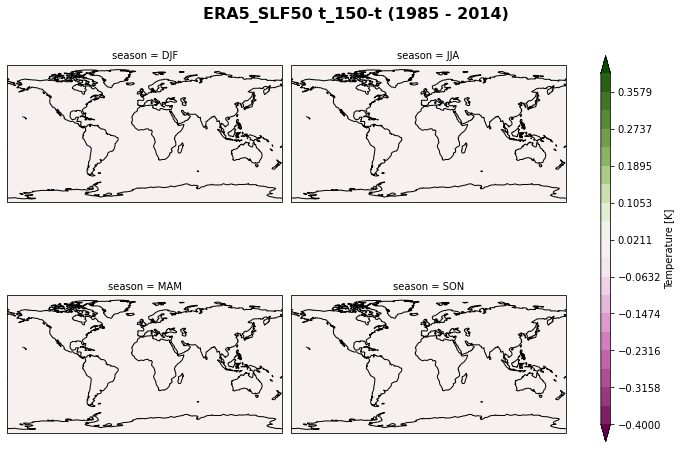

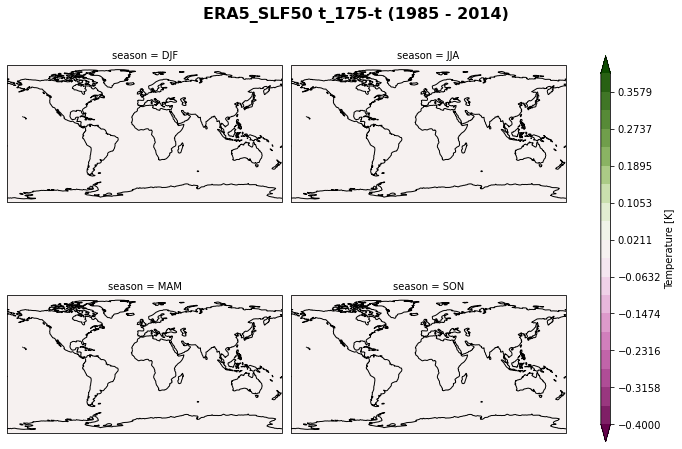

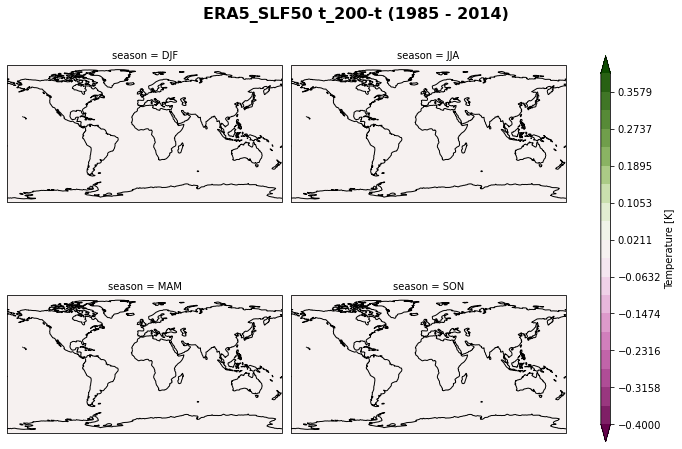

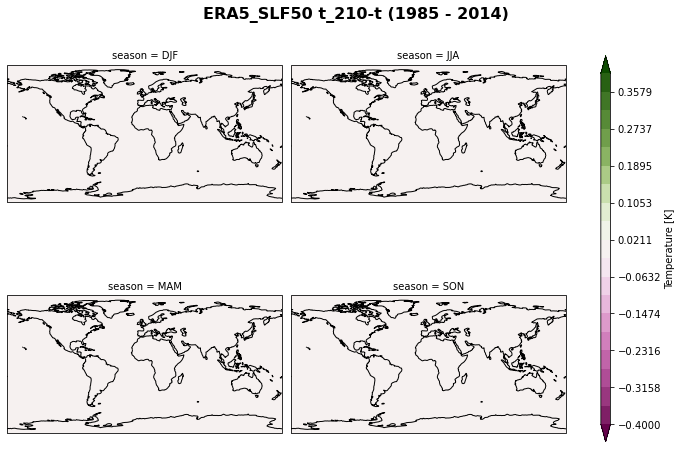

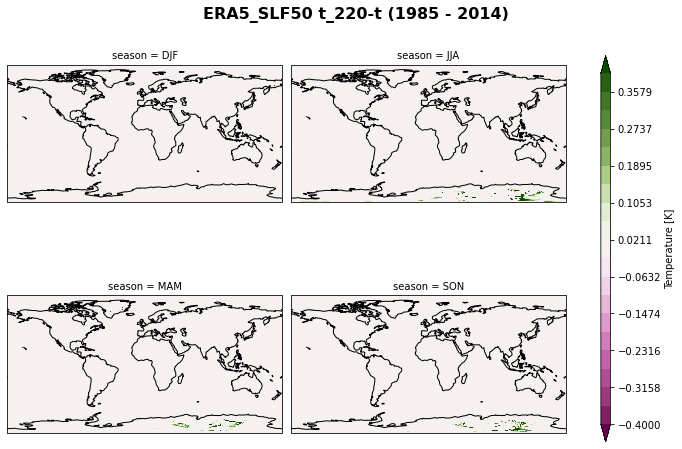

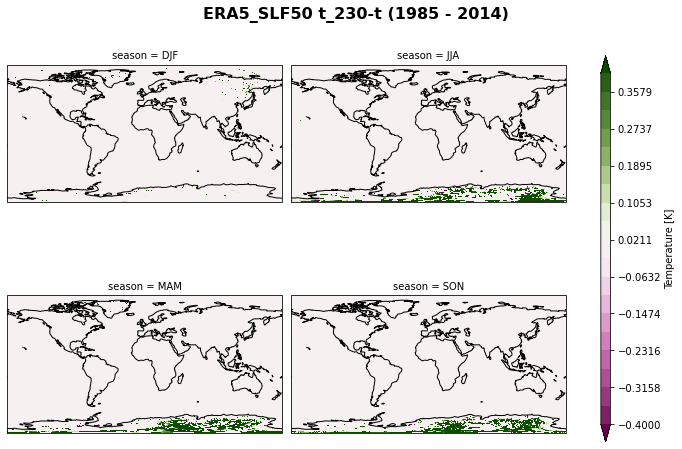

In [23]:
var_id = 't'
for t in temp:
    title = '{} {}_{}-{} ({} - {})'.format(stat, var_id, t, var_id, starty, endy)
    _diff = season_mean_025deg['{}_{}_mean'.format(var_id,t)].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True) - season_mean_025deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
    
    fg = _diff.plot(col="season",
                col_wrap=2,
                transform=ccrs.PlateCarree(),  # remember to provide this!
                subplot_kws={
                    "projection": ccrs.PlateCarree()
                },
                cbar_kwargs={"orientation": "vertical", "shrink": 0.8, "aspect": 40},
                cmap=cm.bam, 
                figsize=[10, 7],
                robust=True,
                extend=extend,
                vmin=-0.4,
                vmax=0.4,
                levels=20,
                )

    fg.map(lambda: plt.gca().coastlines())
    fg.fig.suptitle(title, fontsize=16, fontweight="bold")

In [ ]:
# for stat in season_mean_1deg.statistic.values:
#     for var_id in ds_era.data_vars:
#         if var_id == '2t' or var_id=='t' or var_id=='pressure':
#             extend='both'
#         else:
#             extend='max'
#         if stat == 'ERA5' and var_id.find('occurence')==-1 and (len(ds_era[var_id].dims))==3:
#             # print(stat, var_id)
            
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat, level=1000)#.sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat, level=1000).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id,extend)
            
#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)


#         elif stat!= 'ERA5' and var_id.find('occurence')==-1:
#             # print(stat, var_id)
#             variable = season_mean_1deg[var_id+'_mean'].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True)
            
#             global_mean = ds_era_1deg[var_id].sel(statistic=stat).sum('level', skipna=True, keep_attrs=True).mean(('lat', 'lon'),skipna=True, keep_attrs=True).groupby("time.season").mean("time", skipna=True, keep_attrs=True)
            


#             title = '{} MEAN ({} - {})'.format(stat, starty, endy)
#             fct.plt_spatial_seasonal_mean(variable, global_mean, title, var_id, extend)

#             # save seasonal mean + std figure to png
#             figname = '{}_{}_season_mean_1deg_{}_{}.png'.format(var_id,stat, starty, endy)
#             plt.savefig(FIG_DIR + figname, format = 'png', bbox_inches = 'tight', transparent = False)



In [24]:
lat_SH = (-90, -40); lat_NH = (40,90); step = 5
iteration_SH = range(lat_SH[1], lat_SH[0], -step)
iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [34]:
markers = ['o', 'v', 's']

In [25]:
for _lat in iteration_SH:
    print(_lat-step, _lat, ds_era_1deg.sel(statistic=stat, lat=slice(_lat-step, _lat)).lat.values)

-45 -40 [-44.76439791 -43.82198953 -42.87958115 -41.93717277 -40.9947644
 -40.05235602]
-50 -45 [-49.47643979 -48.53403141 -47.59162304 -46.64921466 -45.70680628]
-55 -50 [-54.18848168 -53.2460733  -52.30366492 -51.36125654 -50.41884817]
-60 -55 [-59.84293194 -58.90052356 -57.95811518 -57.01570681 -56.07329843
 -55.13089005]
-65 -60 [-64.55497382 -63.61256545 -62.67015707 -61.72774869 -60.78534031]
-70 -65 [-69.26701571 -68.32460733 -67.38219895 -66.43979058 -65.4973822 ]
-75 -70 [-74.92146597 -73.97905759 -73.03664921 -72.09424084 -71.15183246
 -70.20942408]
-80 -75 [-79.63350785 -78.69109948 -77.7486911  -76.80628272 -75.86387435]
-85 -80 [-84.34554974 -83.40314136 -82.46073298 -81.51832461 -80.57591623]
-90 -85 [-90.         -89.05759162 -88.11518325 -87.17277487 -86.23036649
 -85.28795812]


In [78]:
ds_dict = {}
for _lat in iteration_NH:
    # print(_lat, _lat+step, ds_era_025deg.sel(statistic=stat, latitude=slice(_lat+step, _lat)).latitude.values)
    ds_dict['{}_{}'.format(_lat, _lat+step)] = ds_era_025deg.sel(latitude = slice(_lat+step, _lat), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)

for _lat in iteration_SH:
    ds_dict['{}_{}'.format(_lat, _lat-step)] = ds_era_025deg.sel(latitude = slice(_lat, _lat-step), ).mean(('longitude', 'latitude', 'level'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)



In [79]:
_ds = list(ds_dict.values())
_coord = list(ds_dict.keys())
ds_lat = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'lat'})


KeyboardInterrupt: 

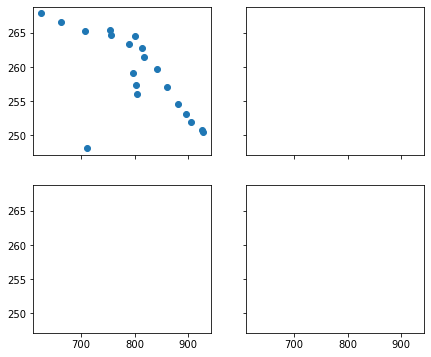

In [89]:
season ='DJF'
ds_lat.sel(statistic='ERA5_SLF50').plot.scatter(col="season",col_wrap=2,
                                                x='pressure', y='t', 
                                                #size=[10, 7],
                                                cmap=cm.hawaii,)
# ,lat='{}_{}'.format(_lat, _lat-step) label='[{} : {})'.format(_lat-step, _lat)

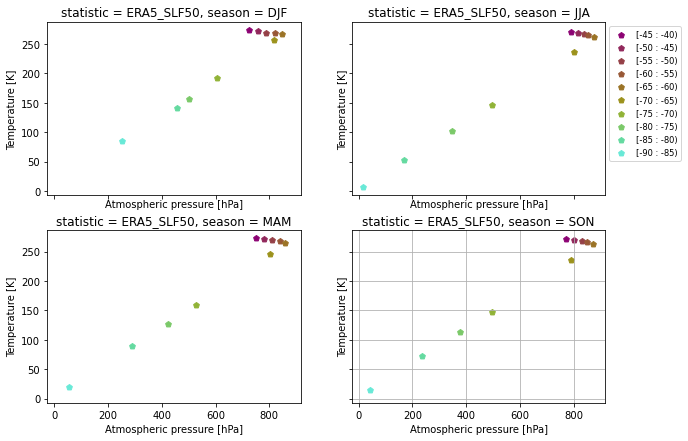

In [39]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

        _season=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level', skipna=True, keep_attrs=True).sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
        # if season =='DJF':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                   x='pressure', y='t',
        #                                                                   label='[{} : {})'.format(_lat-step, _lat),
        #                                                                   color=c, marker=marker)
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)
        
        # if season=='MAM':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)
        
        # if season=='JJA':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                   x='pressure', y='t',
        #                                                                   label='[{} : {})'.format(_lat-step, _lat),
        #                                                                   color=c, marker=marker)

        # if season=='SON':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
plt.grid()

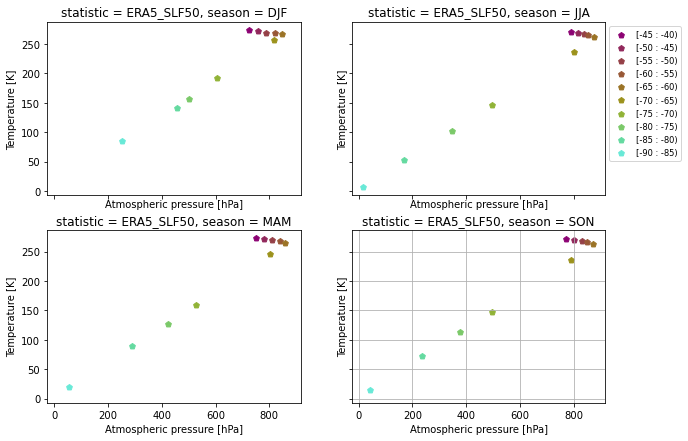

In [40]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_SH, cm.hawaii(range(0, 256, int(256/len(iteration_SH))))):

        _season=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level').sel(lat = slice(_lat-step, _lat)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic=stat, season=season).plot.scatter(ax=ax, x='pressure', y='t_220', label='[{} : {})'.format(_lat-step, _lat), color=c, marker='p')
        # if season =='DJF':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[11:], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                   x='pressure', y='t',
        #                                                                   label='[{} : {})'.format(_lat-step, _lat),
        #                                                                   color=c, marker=marker)
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[:2], markers[1:]):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)
        
        # if season=='MAM':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[2:5], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)
        
        # if season=='JJA':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[5:8], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                   x='pressure', y='t',
        #                                                                   label='[{} : {})'.format(_lat-step, _lat),
        #                                                                   color=c, marker=marker)

        # if season=='SON':
        #     for month, marker in zip(_month.sel(statistic=stat).month.values[8:11], markers):
        #         _month.sel(statistic=stat, month=month).plot.scatter(ax=ax, 
        #                                                                  x='pressure', y='t',
        #                                                                  label='[{} : {})'.format(_lat-step, _lat),
        #                                                                  color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)
plt.grid()

In [70]:
for _lat in iteration_NH:
    print(_lat, _lat+step, ds_era_1deg.sel(statistic='ERA5_50', lat=slice(_lat, _lat+step)).lat.values)

40 45 [40.05235602 40.9947644  41.93717277 42.87958115 43.82198953 44.76439791]
45 50 [45.70680628 46.64921466 47.59162304 48.53403141 49.47643979]
50 55 [50.41884817 51.36125654 52.30366492 53.2460733  54.18848168]
55 60 [55.13089005 56.07329843 57.01570681 57.95811518 58.90052356 59.84293194]
60 65 [60.78534031 61.72774869 62.67015707 63.61256545 64.55497382]
65 70 [65.4973822  66.43979058 67.38219895 68.32460733 69.26701571]
70 75 [70.20942408 71.15183246 72.09424084 73.03664921 73.97905759 74.92146597]
75 80 [75.86387435 76.80628272 77.7486911  78.69109948 79.63350785]
80 85 [80.57591623 81.51832461 82.46073298 83.40314136 84.34554974]
85 90 [85.28795812 86.23036649 87.17277487 88.11518325 89.05759162 90.        ]


In [71]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

        _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='clic', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
        if season =='DJF':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='t', y='clic',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='clic',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='MAM':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='clic',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='JJA':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='t', y='clic',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)

        if season=='SON':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='clic',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

        _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='t', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
        if season =='DJF':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='t', y='sf',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='MAM':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='JJA':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='t', y='sf',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)

        if season=='SON':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='t', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

        _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='sf', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
        if season =='DJF':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='pressure', y='sf',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='MAM':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='JJA':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='pressure', y='sf',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)

        if season=='SON':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='sf',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

In [ ]:
fig, axsm = plt.subplots(2,2, figsize=[10,7],sharex=True, sharey=True)
axs = axsm.flatten()
for ax, season in zip(axs, season_mean_1deg.season.values):

    for _lat, c in zip(iteration_NH, cm.hawaii(range(0, 256, int(256/len(iteration_NH))))):

        _season=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.season').mean('time', skipna=True, keep_attrs=True)
        _month=ds_era_1deg.sum('level').sel(lat = slice(_lat, _lat+step)).mean(('lon', 'lat'), skipna=True, keep_attrs=True).groupby('time.month').mean('time', skipna=True, keep_attrs=True)
       
        _season.sel(statistic='ERA5_50', season=season).plot.scatter(ax=ax, x='pressure', y='t', label='[{} : {})'.format(_lat, _lat+step), color=c, marker='p')
        if season =='DJF':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[11:], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='pressure', y='t',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[:2], markers[1:]):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='t',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='MAM':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[2:5], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='t',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)
        
        if season=='JJA':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[5:8], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                          x='pressure', y='t',
                                                                          label='[{} : {})'.format(_lat, _lat+step),
                                                                          color=c, marker=marker)

        if season=='SON':
            for month, marker in zip(_month.sel(statistic='ERA5_50').month.values[8:11], markers):
                _month.sel(statistic='ERA5_50', month=month).plot.scatter(ax=ax, 
                                                                         x='pressure', y='t',
                                                                         label='[{} : {})'.format(_lat, _lat+step),
                                                                         color=c, marker=marker)


axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize="small", fancybox=True,)

## Calculate latitude band mean of variables
We will only use high latitudes and the extratropics the latitude bands are as follow:

1. Southern Hemispher:
    - [-30, -45)
    - [-45, -60)
    - [-60, -75)
    - [-75, -90)
2. Northern Hemisphere:
    - [30, 45)
    - [45, 60)
    - [60, 75)
    - [75, 90)

In [ ]:
lat_SH = (-90, -30); lat_NH = (30,90); step = 15
iteration_SH = range(lat_SH[1], lat_SH[0], -step)
iteration_NH = range(lat_NH[0], lat_NH[1], step)

In [ ]:
for var_id in ds_era.keys():
    for _lat in iteration_SH:

        # ERA5 original resolution
        ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat-step)).mean(('lat',), keep_attrs=True, skipna=True)

        # ERA5 regridded resolution
        ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat-step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat-step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

    for _lat in iteration_NH:
        # ERA5 original resolution
        ds_era_025deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_025deg[var_id + '_season_mean'].sel(lat = slice(_lat+step, _lat)).mean(('lat',), keep_attrs=True, skipna=True)

        # ERA5 regridded resolution
        ds_era_1deg[var_id + '_season_{}_{}'.format(_lat, _lat+step)] = ds_era_1deg[var_id + '_season_mean'].sel(lat = slice(_lat, _lat+step)).mean(('lat',), keep_attrs=True, skipna=True)

In [ ]:
for stat in ds_era_1deg.statistic.values:
    # Southern Hemisphere
    fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
    fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

    axs = axsm.flatten()
    for ax, i in zip(axs, ds_era_1deg.season):
        for _lat, c in zip(iteration_SH, cm.romaO(range(0, 256, int(256 / 4)))):
            ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
                        y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat-step)].sel(statistic=stat).sel(season=i), 
                        label="{}, {}".format(_lat, _lat - step), 
                        color=c, 
                        alpha=0.5)

    axs[1].legend(
            loc="upper left",
            bbox_to_anchor=(1, 1),
            fontsize="small",
            fancybox=True,
        );

    # Northern Hemisphere
    fig, axsm = plt.subplots(2, 2, figsize=[10,7], sharex=True, sharey=True)
    fig.suptitle('{}'.format(stat), fontsize=16, fontweight="bold")

    axs = axsm.flatten()
    for ax, i in zip(axs, ds_era_1deg.season):
        for _lat, c in zip(iteration_NH, cm.romaO(range(0, 256, int(256 / 4)))):
            ax.scatter( x=ds_era_1deg['t_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sum('level', skipna=True).sel(season=i), 
                        y=ds_era_1deg['sf_season_{}_{}'.format(_lat, _lat+step)].sel(statistic=stat).sel(season=i), 
                        label="{}, {}".format(_lat, _lat + step), 
                        color=c, 
                        alpha=0.5)

    axs[1].legend(
            loc="upper left",
            bbox_to_anchor=(1, 1),
            fontsize="small",
            fancybox=True,
        );


# References <a id='references'></a>


[1] Zelinka, M. D., Myers, T. A., McCoy, D. T., Po-Chedley, S., Caldwell, P. M., Ceppi, P., et al. (2020). Causes of higher climate sensitivity in CMIP6 models. Geophysical Research Letters, 47, e2019GL085782. https://doi-org.ezproxy.uio.no/10.1029/2019GL085782 

[2] Bjordal, J., Storelvmo, T., Alterskjær, K. et al. Equilibrium climate sensitivity above 5 °C plausible due to state-dependent cloud feedback. Nat. Geosci. 13, 718–721 (2020). https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1 




<img src="https://drive.google.com/uc?id=1zb0LHvipx8JOXLLrCxzYToJM7eNK4eaw"  height="100" />
<img src="https://reliance.rohub.org/static/media/Reliance-logo.433dc2e9.png"  height="100" />

<img src="https://www.uio.no/vrtx/decorating/resources/dist/src2/images/footer/uio-logo-en.svg"  height="100" />
<img src="https://erc.europa.eu/sites/default/files/logo_0.png"  height="100" />
